# Deep Dive into Molecular Search Engine with Towhee

In the [previous tutorial](1_build_molecular_search_engine.ipynb), we built and prototyped a proof-of-concept molecular similar search engine. Now, let's try substructure and superstructure search, and deploy it as a micro-service with Towhee.

## Preparation
If you haven't done so already, please go through our previous tutorial: "[Build a Molecular Search Engine in Minutes](./1_build_molecular_search_engine.ipynb)". To make things easy, we'll repeat the important code blocks below; if you have already executed these blocks, please move on to next section.

### Install Dependencies
First we need to install dependencies such as towhee, rdkit and gradio.

In [1]:
! python -m pip install -q towhee towhee.models rdkit-pypi gradio

Please make sure that you have started a [Milvus service](https://milvus.io/docs/install_standalone-docker.md). This notebook uses [milvus 2.2.10](https://milvus.io/docs/v2.2.x/install_standalone-docker.md) and [pymilvus 2.2.11](https://milvus.io/docs/release_notes.md#2210).

In [2]:
! python -m pip install -q pymilvus==2.2.11

### Prepare the Data
There is a subset of the [Pubchem dataset](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/) (10000 SMILES) used in this demo, everyone can download on [Github](https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi).

In [3]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  561k  100  561k    0     0   242k      0  0:00:02  0:00:02 --:--:--  438k


To use the dataset for molecular search, let's first define the dictionary and helper function:
- `to_images(input)`: convert the input smiles or results to towhee.Image for display.

In [4]:
import pandas as pd
from rdkit.Chem import Draw
from rdkit import Chem
from towhee.types.image_utils import from_pil

df = pd.read_csv('pubchem_10000.smi')

def to_images(data):
    imgs = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        img = from_pil(Draw.MolToImage(mol))
        imgs.append(img)
    return imgs

### Create Milvus Collection

Next to create two collection for substructure and substru"molsearch" collection in Milvus. It's worth to note that the vector field of this collection is the type of "BINARY_VECTOR".

In [5]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

MILVUS_HOST = '127.0.0.1'
MILVUS_PORT = '19530'
connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)

def create_milvus_collection(collection_name, dim):    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='smiles', dtype=DataType.VARCHAR, descrition='SMILES', max_length=500),
    FieldSchema(name='embedding', dtype=DataType.BINARY_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='molecular similarity search')
    collection = Collection(name=collection_name, schema=schema)
    
    index_params = {"index_type": "BIN_FLAT", "params": {"nlist": 1024}, "metric_type": "JACCARD"}
    collection.create_index(field_name="embedding", index_params=index_params)
    
    return collection

collection = create_milvus_collection('molecular_search', 2048)

Then load smiles data to Milvus with Towhee, more details in ["Build a Molecular Search Engine in Minutes"](./1_build_molecular_search_engine.ipynb)

In [6]:
from towhee import ops, pipe

insert_pipe = (pipe.input('df')
                   .flat_map('df', ('smiles', 'id'), lambda df: df.values.tolist())
                   .map('smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .map(('id', 'smiles', 'fp'), 'res', ops.ann_insert.milvus_client(host=MILVUS_HOST, 
                                                                           port=MILVUS_PORT,
                                                                           collection_name='molecular_search'))
                   .output('res')
)

insert_pipe(df)

collection.flush()
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 10000.


## Sub and Super Structure Search

Milvus not only supports searching similar structures of molecular formulas, but also superstructure and substructure searches, you only need to specify the metric types:

- Similarly search: "JACCARD"
- Superstructure search: "SUPERSTRUCTURE"
- Substructure search: "SUBSTRUCTURE"

In [9]:
search_pipe = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('super_id', 'super_score', 'super_smiles'), 
                                     ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  limit=6,
                                                                  param={"metric_type": "SUPERSTRUCTURE", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .flat_map('fp', ('sub_id', 'sub_score', 'sub_smiles'), 
                                     ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  limit=6,
                                                                  param={"metric_type": "SUBSTRUCTURE", "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .window_all('query_smiles', 'query_smiles', lambda x: to_images(x[:1]))
                   .window_all('sub_smiles', 'sub_smiles', to_images)
                   .window_all('super_smiles', 'super_smiles', to_images)
                   .output('query_smiles', 'sub_smiles', 'super_smiles')
)

/Users/chenshiyu/workspace/git/towhee/towhee/datacollection/mixins/display.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(width / 100, height / 100))


query_smiles,sub_smiles,super_smiles
,,

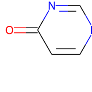
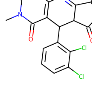
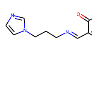
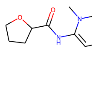
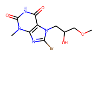
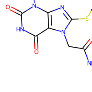
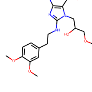
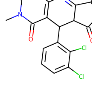
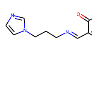
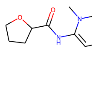
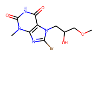
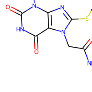
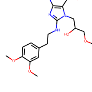
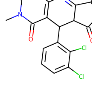
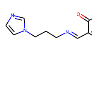
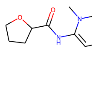
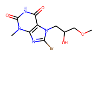
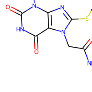
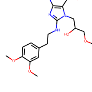
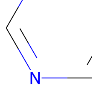
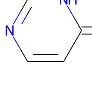
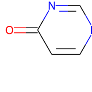

In [10]:
from towhee import DataCollection

res = search_pipe('Cn1ccc(=O)nc1')
DataCollection(res).show()

## Release a Showcase

We've done an excellent job on the core functionality of our molecular search engine. Now it's time to build a showcase with interface. Gradio is a great tool for building demos. With Gradio, we simply need to wrap the data processing pipeline via a `search_smiles_with_metric` function:

In [11]:
def search_smiles_with_metric(smiles, metric_type):
    search_func = (pipe.input('query_smiles')
                   .map('query_smiles', 'fp', ops.molecular_fingerprinting.rdkit(algorithm='daylight'))
                   .flat_map('fp', ('id', 'score', 'similar_smiles'), ops.ann_search.milvus_client(host=MILVUS_HOST, 
                                                                  port=MILVUS_PORT,
                                                                  collection_name='molecular_search',
                                                                  limit=5,
                                                                  param={"metric_type": metric_type, "nprobe": 10},
                                                                  output_fields=['smiles']))
                   .window_all('query_smiles', 'query_smiles', lambda x: to_images(x[:1]))
                   .window_all('similar_smiles', 'similar_smiles', to_images)
                   .output('similar_smiles')
    )
    return search_func(smiles).to_list()[0][0]

In [14]:
import gradio

interface = gradio.Interface(search_smiles_with_metric, 
                             [gradio.inputs.Textbox(lines=1, default='CN1C=NC2=C1C(=O)N(C(=O)N2C)C'), 
                              gradio.inputs.Radio(['JACCARD', 'SUBSTRUCTURE', 'SUPERSTRUCTURE'])],
                             [gradio.outputs.Image(type="pil", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

/Users/chenshiyu/miniconda3/envs/dev-towhee/lib/python3.8/site-packages/gradio/inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/chenshiyu/miniconda3/envs/dev-towhee/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/chenshiyu/miniconda3/envs/dev-towhee/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/chenshiyu/miniconda3/envs/dev-towhee/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/Users/chenshiyu/miniconda3/envs/dev-towhee/lib/python3.8/site-packages/gradio/inputs.py:182: UserWarning: Usage of gradio.inputs is deprecated, and will n

IMPORTANT: You are using gradio version 3.3, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://9d6bc9cc75628221.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://www.huggingface.co/spaces


(<gradio.routes.App at 0x7f97e2c7dca0>,
 'http://127.0.0.1:7861/',
 'https://9d6bc9cc75628221.gradio.app')